In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import seaborn as sb
import numpy as np
from collections import defaultdict
import sys
import chardet

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Distribution of predictability values

In [9]:
def read_in_pred_files(pred_map_filepaths):
    pos_pred_maps = []
    for predictor, filepath in pred_map_filepaths:
        with open(filepath) as f:
            pos_pred_maps.append((predictor,json.load(f)))
    return pos_pred_maps

In [11]:
pred_map_filepaths = [('cloze','../data/predictability/prediction_map_Provo_Corpus_cloze_continuous reading_english.json'),
                      ('GPT2_top10', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk10.json'),
                      ('GPT2_top15', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk15.json'),
                      ('GPT2_top20', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk20.json')]
                      #('GPT2_top50', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk50.json'),
                      #('GPT2_top100', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk100.json'),
                      #('GPT2_top1000', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk1000.json')]
pos_pred_maps = read_in_pred_files(pred_map_filepaths)

In [12]:
def count_pred_values (pos_pred_map):
    # create dict with prediction values as keys and counts as values
    
    pred_value_counts = defaultdict(int)
    for pos_text in pos_pred_map.values():
        for predictions in pos_text.values():
            for pred_value in predictions.values():
                if pred_value != 1.025: # to exclude mistaken value from data
                    pred_value_counts[pred_value] += 1
                    
    # print([value for value,count in pred_value_counts.items() if value > 1])
    return pred_value_counts

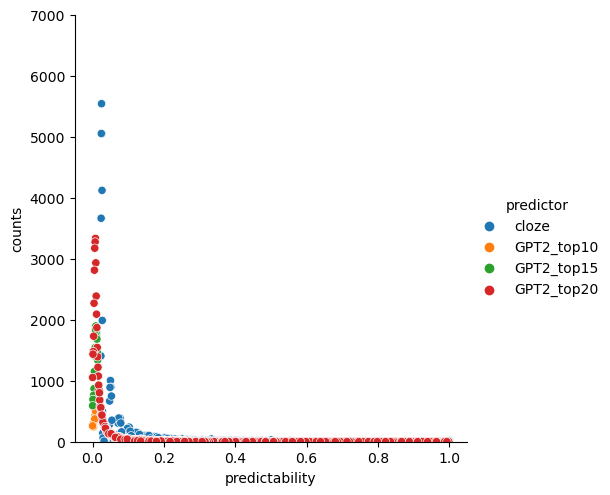

In [13]:
# count pred values in each predictor
pred_values, counts, predictors = [],[],[]

for predictor, pos_pred_map in pos_pred_maps:
    pred_value_counts = count_pred_values(pos_pred_map)
    pred_values.extend(pred_value_counts.keys())
    counts.extend(pred_value_counts.values())
    
    for pred_value in range(len(pred_value_counts.keys())): 
        predictors.append(predictor)
        
    assert len(pred_values) == len(counts) == len(predictors), print(len(pred_values),len(counts),len(predictors)) 

    pred_value_counts_col = {'predictability': pred_values,
                             'counts': counts,
                             'predictor': predictors}

ax = sb.relplot(data=pred_value_counts_col, x = 'predictability', y = 'counts', hue = 'predictor', kind = 'scatter')
ax.set(ylim=(0, 7000))

In [14]:
# read in stimulus (true words)
stimulus_filepath = '../data/predictability/Provo_Corpus-Predictability_Norms.csv'
# encoding = chardet.detect(open(stimulus_filepath, "rb").read())['encoding']
encoding = "ISO-8859-1"
data = pd.read_csv(stimulus_filepath, encoding=encoding)

words_in_text = []
for word_info, rows in data.groupby(['Text_ID','Word_Number','Word']):
     words_in_text.append(word_info[-1])
# print(words_in_text)

In [15]:
def count_pred_values_text (pos_pred_map,text_words):
    # create dict with prediction values as keys and counts as values
    
    pred_value_counts = defaultdict(int)
    for pos_text in pos_pred_map.values():
        for position, predictions in pos_text.items():
            word_in_text = text_words[int(position)]
            if word_in_text in predictions.keys():
                pred_value = predictions[word_in_text]
                if pred_value != 1.025: # to exclude mistaken value from cloze data
                    pred_value_counts[pred_value] += 1
                    
    # print([value for value,count in pred_value_counts.items() if value > 1])
    return pred_value_counts

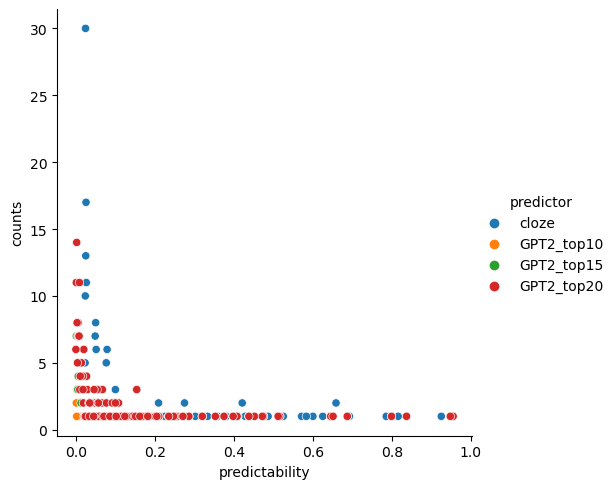

In [16]:
# count pred values in each predictor only including the predictability of target words (words in text)
pred_values, counts, predictors = [],[],[]

for predictor, pos_pred_map in pos_pred_maps:
    pred_value_counts = count_pred_values_text(pos_pred_map, words_in_text)
    pred_values.extend(pred_value_counts.keys())
    counts.extend(pred_value_counts.values())
    
    for pred_value in range(len(pred_value_counts.keys())): 
        predictors.append(predictor)
        
    assert len(pred_values) == len(counts) == len(predictors), print(len(pred_values),len(counts),len(predictors)) 

    pred_value_counts_col = {'predictability': pred_values,
                             'counts': counts,
                             'predictor': predictors}

ax = sb.relplot(data=pred_value_counts_col, x = 'predictability', y = 'counts', hue = 'predictor', kind = 'scatter')

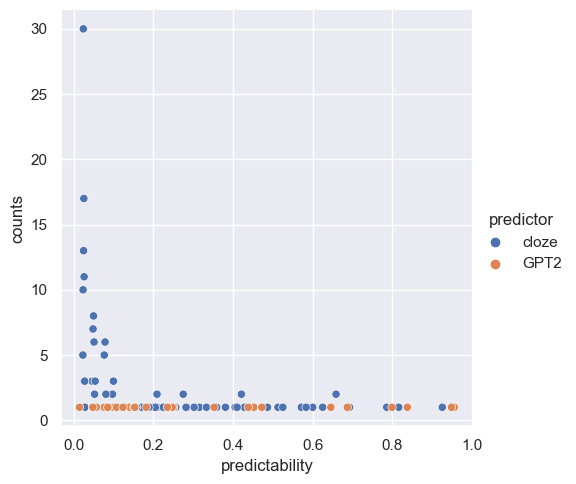

In [82]:
# count pred values in each predictor only including the predictability of target words (words in text) AND taking the pred value of word in text in GPT2, independently of being in topk
# round pred values gpt2 to 2 decimals
pred_map_filepaths_target = [('cloze','../data/predictability/prediction_map_Provo_Corpus_cloze_continuous reading_english.json'),
                          ('GPT2', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topktarget_word.json')]
pos_pred_maps_target = read_in_pred_files(pred_map_filepaths_target)

pred_values, counts, predictors = [],[],[]

for predictor, pos_pred_map in pos_pred_maps_target:
    pred_value_counts = count_pred_values_text(pos_pred_map, words_in_text)
    pred_values.extend(pred_value_counts.keys())
    counts.extend(pred_value_counts.values())
    
    for pred_value in range(len(pred_value_counts.keys())): 
        predictors.append(predictor)
        
    assert len(pred_values) == len(counts) == len(predictors), print(len(pred_values),len(counts),len(predictors)) 

    pred_value_counts_col = {'predictability': pred_values,
                             'counts': counts,
                             'predictor': predictors}

ax = sb.relplot(data=pred_value_counts_col, x = 'predictability', y = 'counts', hue = 'predictor', kind = 'scatter')

In [17]:
# proportion of known and unknown predicted tokens in relation to model lexicon
unknown_map_filepaths = [('cloze','../data/predictability/prediction_map_Provo_Corpus_cloze_continuous reading_english_unknown.json'),
                      ('GPT2_top10', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk10_unknown.json'),
                      ('GPT2_top15', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk15_unknown.json'),
                      ('GPT2_top20', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk20_unknown.json'),
                      ('GPT2_top50', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk50_unknown.json'),
                      ('GPT2_top100', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk100_unknown.json')]
                      #('GPT2_top1000', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk1000_unknown.json')]

pos_pred_maps_unknown = read_in_files(unknown_map_filepaths)

predictors, counts, category = [],[],[]

for known_map, unknown_map in zip(pos_pred_maps,pos_pred_maps_unknown):
    counts.append(sum([len(words.keys()) for text, info in known_map[1].items() if info for idx, words in info.items()]))
    counts.append(sum([len(words.keys()) for text, info in unknown_map[1].items() if info for idx, words in info.items()]))
    predictors.extend([known_map[0],unknown_map[0]])
    category.extend(['known', 'unknown'])
    
assert len(predictors) == len(counts) == len(category)

n_known_tokens = {'predictor': predictors, 'category': category, 'counts': counts}

sb.set(rc={'figure.figsize': (10,5)})
ax = sb.barplot(n_known_tokens, x='predictor',y='counts', hue='category')
for i in ax.containers:
    ax.bar_label(i,)

NameError: name 'read_in_files' is not defined

In [59]:
# counts of prediction values for GPT2 over whole vocab vs. cloze
# proportion of lexicon that does not align with a GPT2 token and do not align with a cloze predicted word

# Word prediction accuracy

In [20]:
# read in stimulus (true words)
stimulus_filepath = '../data/predictability/Provo_Corpus-Predictability_Norms.csv'
# encoding = chardet.detect(open(stimulus_filepath, "rb").read())['encoding']
encoding = "ISO-8859-1"
data = pd.read_csv(stimulus_filepath, encoding=encoding)

words_in_text = []
for word_info, rows in data.groupby(['Text_ID','Word_Number','Word']):
     words_in_text.append(word_info[-1])
#print(words_in_text)

In [21]:
# get predictions from cloze
predicted_words_cloze = [list(predictions.keys()) for pos_text in pos_pred_maps[0][1].values() for predictions in pos_text.values()]

# get predictions from gpt2
predicted_words_gpt2 = dict()
for topk in pos_pred_maps[1:]:
    pred_words = [list(predictions.keys()) for pos_text in topk[1].values() for predictions in pos_text.values()]
    predicted_words_gpt2[topk[0]] = pred_words

# print(predicted_words_cloze)
# print(predicted_words_gpt2)

In [22]:
accuracy_scores = defaultdict(list)

# acc cloze
acc_between_cloze = sum([1 if word in pred_words else 0 for word, pred_words in zip(words_in_text,predicted_words_cloze)])/len(words_in_text)
accuracy_scores['predictor'].append('cloze')
accuracy_scores['accuracy'].append(acc_between_cloze)

# acc different topk gpt2
for topk, predictions in predicted_words_gpt2.items():
    acc_gpt2 = sum([1 if word in pred_words else 0 for word, pred_words in zip(words_in_text,predictions)])/len(words_in_text)
    accuracy_scores['predictor'].append(topk)
    accuracy_scores['accuracy'].append(acc_gpt2)
    
print(accuracy_scores)

defaultdict(<class 'list'>, {'predictor': ['cloze', 'GPT2_top10', 'GPT2_top15', 'GPT2_top20'], 'accuracy': [0.2760416666666667, 0.08891369047619048, 0.10379464285714286, 0.11607142857142858]})


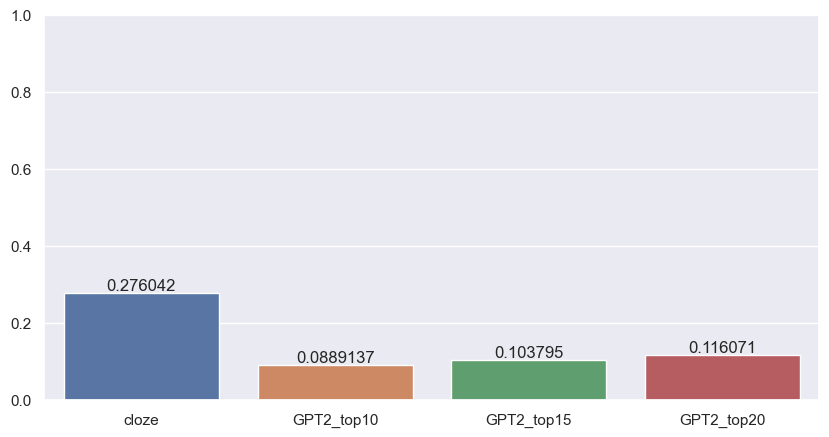

In [23]:
sb.set(rc={'figure.figsize': (10,5)})
ax = sb.barplot(accuracy_scores, x='predictor',y='accuracy')
ax.set(ylim=(0.0, 1.0))
for i in ax.containers:
    ax.bar_label(i,)
# email authors

# Word-level eye measures

In [84]:
# read in simulation output
simulation_filepath = '../results/simulation_Provo_Corpus_continuous reading__31_05_2023_15-34-05.csv'
sim_results = pd.read_csv(simulation_filepath, sep='\t')
sim_results

,fixation_counter,foveal word,foveal word index,attentional width,foveal word frequency,foveal word predictability,foveal word length,foveal word threshold,offset,saccade type,...,eye position,n ngrams,total ngram activity,foveal word activity per cycle,foveal word-to-word inhibition per cycle,stimulus activity per cycle,lexicon activity per cycle,foveal word activity at shift,fixation duration,recognized word at position
0,0,there,0,15.0,6.72,0.000000,5,0.494863,0.000000,NaN,...,2,17,4.202037,"[0.14466685419660058, 0.25519558634798145, 0.3...","[7.393893327573187e-05, 0.00029561450532090045...","[0.30757371052475807, 0.5498370822805353, 0.74...","[24.932456058374918, 46.64904102296465, 65.563...",0.519281,275,['there' 'are' None None 'that' 'apple' 'might...
1,1,are,1,5.0,6.82,0.031867,3,0.493299,0.989662,forward,...,9,34,5.502419,"[0.1967861264129913, 0.24866579507491948, 0.29...","[0.0031526030258836896, 0.0031170626951061114,...","[0.9272726813848751, 1.0583062477417686, 1.168...","[149.88483376343228, 154.26744589686118, 158.1...",0.196786,125,['there' 'are' None None 'that' 'apple' 'might...
2,2,rumblings,3,5.0,2.70,0.000124,9,0.557757,-0.355755,wordskip,...,12,38,5.486534,"[0.2815208737792262, 0.3344010700496728, 0.376...","[0.00019193119796909818, 0.0002251041840933664...","[1.418672676587608, 1.4909954685660498, 1.5501...","[169.44049898714, 173.55966754936244, 177.1664...",0.518069,375,['there' 'are' None None 'that' 'apple' 'might...
3,3,now,2,5.0,6.44,0.006670,3,0.499244,0.779263,regression,...,13,38,5.752151,"[0.41095231785354663, 0.4267191364840438, 0.43...","[0.0008381728340231401, 0.0008880723218485535,...","[1.8493420032680943, 1.8847762270467834, 1.914...","[194.142785845306, 195.69938978210882, 197.013...",0.483546,350,['there' 'are' None None 'that' 'apple' 'might...
4,4,rumblings,3,3.0,2.70,0.000124,9,0.557757,0.693660,forward,...,13,38,5.604358,"[0.5155189734071514, 0.5240525407208274, 0.530...","[0.00043834820397815313, 0.0004775527369850762...","[1.8263551530814426, 1.8297741889536778, 1.832...","[203.34247797371899, 205.4531394473032, 207.25...",0.551763,350,['there' 'are' None None 'that' 'apple' 'might...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,a,55,5.0,7.38,0.124607,1,0.484537,1.396466,forward,...,10,20,3.602640,"[0.2637027539462197, 0.25780222800476377, 0.25...","[0.00611989640766911, 0.00592314209344923, 0.0...","[1.5381186294820588, 1.527129970812735, 1.5164...","[181.71262215601544, 180.88659049088537, 180.0...",0.229085,400,['there' 'are' None None 'that' 'apple' 'might...
61,61,of,54,5.0,7.27,0.169389,2,0.486258,0.324633,regression,...,11,24,4.688445,"[0.46420066800549065, 0.4952315389559628, 0.13...","[0.0008270487108017518, 0.0009150224481777289,...","[1.7168865306047316, 1.774263187493428, 1.4427...","[172.64248601006324, 173.69565945241646, 174.2...",0.385131,250,['there' 'are' None None 'that' 'apple' 'might...
62,62,song,56,3.0,5.10,0.574285,4,0.520209,-0.156732,wordskip,...,7,11,2.882860,"[0.49506752501456724, 0.517848863305664, 0.528...","[0.0016038769380779538, 0.0016997847207691778,...","[1.1039255183876355, 1.099006923259207, 1.1029...","[171.59490482374883, 166.69495584234068, 163.2...",0.517849,150,['there' 'are' None None 'that' 'apple' 'might...
63,63,a,55,3.5,7.38,0.124607,1,0.484537,-1.000000,regression,...,8,20,3.684677,"[0.21568575836488885, 0.22660690030400293, 0.2...","[0.004223322838506892, 0.004440318753742972, 0...","[1.3405915997960274, 1.3698659662436505, 1.395...","[155.69825376429384, 156.6643593498729, 157.51...",0.272909,350,['there' 'are' None None 'that' 'apple' 'might...


In [74]:
# read in words that have been skipped and never fixated (they are not included in fixation data,
# but should be considered for wordskip results
skipped_filepath = '../results/skipped_words_Provo_Corpus_continuous reading__31_05_2023_15-34-05.csv'


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,"{'foveal word': 'there', 'foveal word index': ...","{'foveal word': 'are', 'foveal word index': 1,...","{'foveal word': 'rumblings', 'foveal word inde...","{'foveal word': 'that', 'foveal word index': 4...","{'foveal word': 'rumblings', 'foveal word inde...","{'foveal word': 'apple', 'foveal word index': ...","{'foveal word': 'might', 'foveal word index': ...","{'foveal word': 'might', 'foveal word index': ...","{'foveal word': 'soon', 'foveal word index': 7...","{'foveal word': 'invade', 'foveal word index':...",...,"{'foveal word': 'to', 'foveal word index': 48,...","{'foveal word': 'view', 'foveal word index': 4...","{'foveal word': 'the', 'foveal word index': 50...","{'foveal word': 'artist', 'foveal word index':...","{'foveal word': 'and', 'foveal word index': 52...","{'foveal word': 'title', 'foveal word index': ...","{'foveal word': 'of', 'foveal word index': 54,...","{'foveal word': 'song', 'foveal word index': 5...","{'foveal word': 'a', 'foveal word index': 55, ...","{'foveal word': 'song', 'foveal word index': 5..."


In [ ]:
# read in PROVO eye-tracking data
eye_tracking_filepath = '../data/eye_tracking/Provo_Corpus-Eyetracking_Data.csv'
eye_track_df = pd.read_csv(eye_tracking_filepath, encoding="ISO-8859-1")

In [71]:
# --------- Get data frame with all tokens ---------
# data frame with columns = keys from dict of each fixation and rows = each fixation instance
print(simulation_results)
df_sim_results = pd.DataFrame.from_dict(simulation_results, orient='index')
# add skipped words
df_skipped_words = pd.DataFrame.from_records(skipped_words)
df_skipped_words['wordskip'] = True
df_all_tokens = pd.concat([df_sim_results,df_skipped_words], axis=0)
df_all_tokens.fillna({'wordskip': False, 'fixation duration': 0.0}, inplace=True)
df_all_tokens = df_all_tokens.set_index('foveal word index')
df_all_tokens = df_all_tokens.sort_index()

[{0: defaultdict(<class 'list'>, {'foveal word': 'there', 'foveal word index': 0, 'attentional width': 15, 'foveal word frequency': 6.72, 'foveal word predictability': 0, 'foveal word length': 5, 'foveal word threshold': 0.49486310299869624, 'offset': 0, 'saccade type': None, 'saccade error': 0, 'saccade distance': 0, 'saccade cause': 0, 'saccade type by error': False, 'stimulus': 'there are now', 'eye position': 2, 'n ngrams': 17, 'total ngram activity': 4.202036682368469, 'foveal word activity per cycle': [0.14466685419660064, 0.25519558634798156, 0.33958914051856526, 0.4040051634452002, 0.4531624775551106, 0.4906692262008941, 0.5192811999873126, 0.10085868986479715, 0.18238574402080213, 0.24830529848924807, 0.3015994337769681], 'foveal word-to-word inhibition per cycle': [7.393893327573195e-05, 0.0002956145053208998, 0.0005940144937571939, 0.0009226771650890657, 0.0012533439527637486, 0.0015696162952915963, 0.0018627109718123908, 0.0019343803092997864, 0.0020254430808509852, 0.00209

AttributeError: 'list' object has no attribute 'values'

In [ ]:
# --------- General fixation duration measures  ---------
# saccade type counts
saccade_type_counts = df_sim_results['saccade type'].value_counts()
# total viewing time for each token
sum_fixation_duration = df_all_tokens.groupby(['foveal word index'])[['fixation duration']].sum()
# first pass
first_pass_indices = []
for word, fix_hist in df_sim_results.groupby(['foveal word index']):
  for i, fix in fix_hist.iterrows():
    if 'regression' not in fix_hist['saccade type'].tolist():
      first_pass_indices.append(i)
    elif i < fix_hist['saccade type'].tolist().index('regression'):
      first_pass_indices.append(i)
first_pass = df_sim_results.filter(items=first_pass_indices,axis=0)
# first fixation
first_fixation = first_pass.loc[first_pass.groupby(['foveal word index']).apply(lambda x: x.index[0]).values,:][['foveal word','foveal word index','fixation duration']]
# refixations
refixations = first_pass.groupby(['foveal word index']).filter(lambda x:len(x)>1)
# second fixation
second_fixations = first_pass.loc[refixations.groupby(['foveal word index']).apply(lambda x: x.index[1]).values,:][['foveal word','foveal word index','fixation duration']]
# gaze duration
gaze_duration = first_pass.groupby(['foveal word index'])[['fixation duration']].sum()

# Predictability Effects